# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

# Loading Datasets

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s3e3/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e3/test.csv")
original=pd.read_csv("/kaggle/input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv")
sub =pd.read_csv("/kaggle/input/playground-series-s3e3/sample_submission.csv")

In [3]:
train.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,...,80,1,10,2,3,10,0,7,8,0
1,1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,...,80,1,4,3,3,4,2,0,3,0
2,2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,...,80,2,4,3,3,3,2,1,2,0
3,3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,...,80,0,15,1,1,6,0,0,2,0
4,4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,...,80,0,31,0,3,31,14,4,10,1


In [4]:
test.head()

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1677,19,Non-Travel,992,Research & Development,1,1,Medical,1,4,...,4,80,0,1,2,2,1,0,0,0
1,1678,45,Travel_Rarely,1136,Sales,4,4,Marketing,1,3,...,3,80,1,7,3,3,2,2,2,2
2,1679,37,Travel_Rarely,155,Research & Development,13,3,Life Sciences,1,4,...,2,80,2,13,2,2,7,7,1,7
3,1680,32,Travel_Rarely,688,Research & Development,1,4,Life Sciences,1,3,...,3,80,0,14,2,2,14,10,11,8
4,1681,29,Travel_Frequently,464,Research & Development,9,1,Life Sciences,1,3,...,1,80,0,1,5,3,1,0,0,0


In [5]:
original.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [6]:
print(train.shape)
print(test.shape)
print(original.shape)

(1677, 35)
(1119, 34)
(1470, 35)


In [7]:
original = original.rename(columns={'EmployeeNumber': 'id'})
original['Attrition'] = (original['Attrition'] == 'Yes').astype(int)

original = original[train.columns.tolist()]

original['source'] = 'original'
train['source'] = 'synthetic'
test['source'] = 'synthetic'

train = pd.concat([train, original])
train.reset_index(inplace=True, drop=True)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3147 entries, 0 to 3146
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        3147 non-null   int64 
 1   Age                       3147 non-null   int64 
 2   BusinessTravel            3147 non-null   object
 3   DailyRate                 3147 non-null   int64 
 4   Department                3147 non-null   object
 5   DistanceFromHome          3147 non-null   int64 
 6   Education                 3147 non-null   int64 
 7   EducationField            3147 non-null   object
 8   EmployeeCount             3147 non-null   int64 
 9   EnvironmentSatisfaction   3147 non-null   int64 
 10  Gender                    3147 non-null   object
 11  HourlyRate                3147 non-null   int64 
 12  JobInvolvement            3147 non-null   int64 
 13  JobLevel                  3147 non-null   int64 
 14  JobRole                 

In [9]:
train.nunique().sort_values()

StandardHours                  1
Over18                         1
EmployeeCount                  1
source                         2
PerformanceRating              2
OverTime                       2
Attrition                      2
Gender                         2
MaritalStatus                  3
Department                     3
BusinessTravel                 3
WorkLifeBalance                4
StockOptionLevel               4
RelationshipSatisfaction       4
JobSatisfaction                4
EnvironmentSatisfaction        4
JobInvolvement                 4
Education                      6
EducationField                 6
JobLevel                       6
TrainingTimesLastYear          7
JobRole                        9
NumCompaniesWorked            10
PercentSalaryHike             15
YearsSinceLastPromotion       16
YearsWithCurrManager          18
YearsInCurrentRole            19
DistanceFromHome              29
YearsAtCompany                38
TotalWorkingYears             41
Age       

# Preprocessing

In [10]:
feats_to_drop = [col for col in train.columns if train[col].nunique()==1]

In [11]:
train.drop(columns=feats_to_drop, inplace=True)
test.drop(columns=feats_to_drop, inplace=True)

In [12]:
object_feat=list((train.dtypes[train.dtypes == 'object']).index)
object_feat

['BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'OverTime',
 'source']

In [13]:
le = LabelEncoder()
for i in object_feat:
    train[i] = le.fit_transform(train[i])
    test[i] = le.transform(test[i])

# Modelling

In [14]:
# Source - https://www.analyseup.com/learn-python-for-data-science/python-random-forest-feature-importance-plot.html

def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [15]:
X = train.drop('Attrition', axis=1)
y = train['Attrition']
SPLITS = 10
RANDOM = 50
ESTIMATORS = 1000
clfs = []
scores = []
y_pred = []

In [16]:
skf = StratifiedKFold(n_splits = SPLITS, shuffle = True, random_state = RANDOM)

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.loc[train_idx], X.loc[test_idx]    
    y_train, y_test = y[train_idx], y[test_idx]    
    clf = CatBoostClassifier(n_estimators = ESTIMATORS)
    clf.fit(X_train.values, y_train, eval_set = [(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    preds = clf.predict_proba(X_test.values)    
    clfs.append(clf)
    scores.append(roc_auc_score(y_test, preds[:, 1]))
print(f'mean score: {np.mean(scores)}')

mean score: 0.8553004298541926


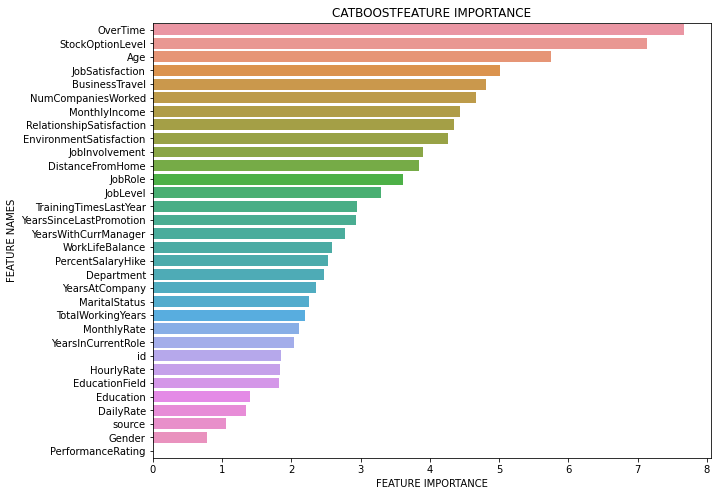

In [17]:
plot_feature_importance(clf.feature_importances_,X_train.columns,'CATBOOST')

In [18]:
skf = StratifiedKFold(n_splits = SPLITS, shuffle = True, random_state = RANDOM)

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.loc[train_idx], X.loc[test_idx]    
    y_train, y_test = y[train_idx], y[test_idx]    
    clf1 = XGBClassifier(n_estimators = ESTIMATORS)
    clf1.fit(X_train, y_train, eval_set = [(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    preds = clf1.predict_proba(X_test)    
    clfs.append(clf1)
    scores.append(roc_auc_score(y_test, preds[:, 1]))
print(f'mean score: {np.mean(scores)}')

mean score: 0.8426614196110249


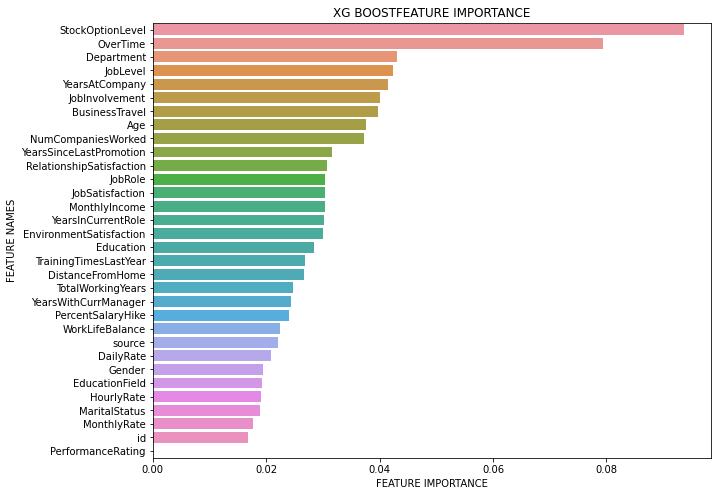

In [19]:
plot_feature_importance(clf1.feature_importances_,X_train.columns,'XG BOOST')

In [20]:
for c in clfs:
    preds = c.predict_proba(test)
    y_pred.append(preds[:, 1])

In [21]:
final_pred=np.stack(y_pred).mean(0)

In [22]:
final_pred

array([0.18353415, 0.09336601, 0.0458654 , ..., 0.04564848, 0.04017495,
       0.02388786])

In [23]:
sub["Attrition"]=final_pred
sub.head()

,id,Attrition
0,1677,0.183534
1,1678,0.093366
2,1679,0.045865
3,1680,0.057433
4,1681,0.426586


In [24]:
sub.to_csv('submission.csv',index=False)